In [1]:
# -- import packages
import matplotlib.pyplot as plt
import numpy as np
import fabio
import loki
import os
import sys
import h5py

sys.path.insert(0, '../../scripts/')
from integrators import*
from utilities import *
from calibrators import*
from fabio_open import*
from h5_tools import*

os.chdir('/Applications/anaconda3/lib/python3.7/site-packages/loki')
from RingData import RingFit, InterpSimple, DiffCorr

In [2]:
# set the directory where to find the data
os.chdir('/Users/nena/OneDrive - fysik.su.se/erasmus/2019-stockholm/master-project/01-data-analysis/XRD/data/2020-01-14')
# True if you want to save the data, False otherwise
save = False

### Open background and calibrator files

In [3]:
# calibrator and bg filenames
silver_fn = 'cu_Lyso_02_AuBehenate.sfrm'
bg_fn = 'cu_Lyso_04_EmptyKap.sfrm'

# import 2d scattering pattern
im_bg = fabio.open(bg_fn)
bg_ar = np.array(im_bg.data,dtype=float)
    
# save 2d pattern w/ and w/o bg in arrays
ar_silver_bg, ar_silver = open_sfrm_file(silver_fn, bg_ar)


### Plot Calibrator (Ag-behenate), bg and calibrator

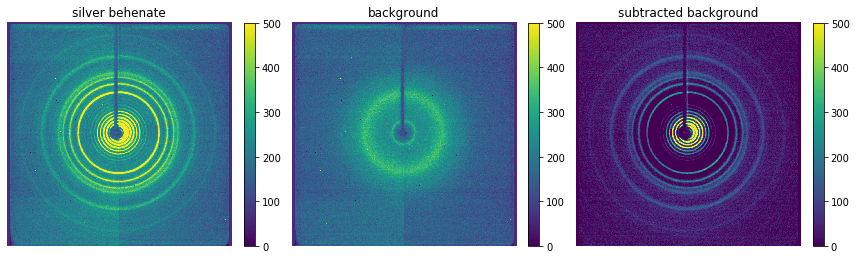

In [4]:
# Silver
vmin,vmax = 0, 500

plt.figure(figsize=(12,5), tight_layout=True)
# Plot Silver with background
plt.subplot(1,3,1)
plt.imshow(ar_silver_bg, vmin=vmin, vmax=vmax)

plt.colorbar(fraction=0.045)
plt.title('silver behenate')
plt.axis('off')

# Plot background
plt.subplot(1,3,2)
plt.imshow(im_bg.data, vmin=vmin, vmax=vmax)
plt.colorbar(fraction=0.045)
plt.title('background')
plt.axis('off')

# Plot Silver without background
plt.subplot(1,3,3)
plt.imshow(ar_silver, vmin=vmin, vmax=vmax)
plt.colorbar(fraction=0.045)
plt.axis('off')
plt.title('subtracted background')

plt.show()


### Center guess

In [5]:
# beam center
cx,cy = 508, 508

# Guess center
center_guess = [cx,cy] # intital guess for center
peak_radius_guess = 41 # initial guess for first peak radius
ring_param_guess = (center_guess[0], center_guess[1], peak_radius_guess)


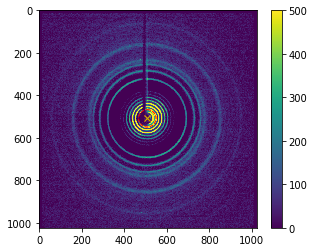

In [6]:
# plot calibrator with initial guesses
plt.figure(figsize=[5,4])
ax = plt.gca()
plt.plot(center_guess[0],center_guess[1],'rx')
plt.plot(507.33,508.6,'yx')
circ = plt.Circle(xy=(center_guess[0], center_guess[1]), radius=peak_radius_guess,
                  lw=1, fc='none', ls='dashed' ,color='r')
plt.imshow(ar_silver,vmax=vmax,vmin=vmin)
ax.add_patch(circ)
plt.colorbar()

plt.show()


### Find center and first ring 

In [7]:
RF = RingFit(ar_silver)
x_center,y_center, peak_radius = RF.fit_circle_slow(ring_param_guess, 
                                                   ring_scan_width=10, 
                                                   center_scan_width=4, 
                                                   resolution=1 )
print('Initial guesses: ', ring_param_guess)
print('Final param: %.2f, %.2f, %d' %(x_center, y_center, peak_radius))

Initial guesses:  (508, 508, 41)
Final param: 507.33, 507.33, 41


/Applications/anaconda3/lib/python3.7/site-packages/loki/RingData/RadialProfile.py:79: RuntimeWarning: invalid value encountered in true_divide
  self.num_pixels_per_radial_bin


In [8]:
# reference Q values of peaks
q_ref = silver_behenate()

In [9]:
# -- angular integration parameters
n_bins = 512       # number of bins
min_x,max_x = 0,512    # n_bins

# -- experimental parameters
p_size = 96e-6        # size of the pixels
d = 50e-3              # detector distance
Cu_energy = 8041.5       # energy of the beam (Cu K\alpha)


In [10]:
# mask used to cover the beam blocker
mask = beam_blocker_mask(nx=1024,ny=1024,center_x=int(507.33),center_y=int(507.33),
                         radius=33,radius2=495,slope=1e-5,offset=-3,thickness=12)


### Radial and angular average

In [11]:
# r-map
rad_dist = radial_distances(ar_silver, center=(int(y_center),int(x_center)))

# method 1
r, iq = angular_average(ar_silver, mask=mask, rad=rad_dist,threshold=0,nx=n_bins)
q = q_scale(r,detector_distance=d,photon_energy=Cu_energy,pixel_size=p_size)

# method 2
ra = RadialAverager(rad_dist, mask=mask, n_bins=n_bins)
iq3 = ra(np.array(ar_silver))
r3  = ra.bin_centers
q3 = q_scale(r3,detector_distance=d,photon_energy=Cu_energy,pixel_size=p_size)


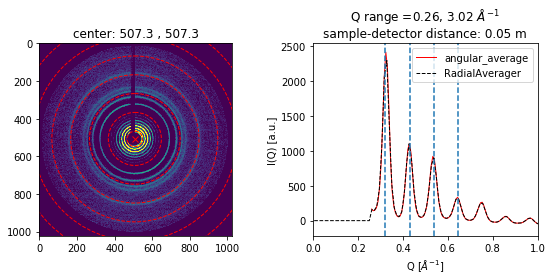

In [12]:
plt.figure(figsize=[8,4])

# plot 2d img of calibrator
plt.subplot(1,2,1)
ax = plt.gca()
plt.plot(x_center,y_center,'rx')
for i in range(10):
    circ = plt.Circle(xy=(x_center, y_center), radius=peak_radius+i*100,
                      lw=1., fc='none', ls='dashed' ,color='r')
    ax.add_patch(circ)
ax.imshow(ar_silver*mask, interpolation='nearest',clim=[0,10], vmax=vmax, vmin=vmin)
plt.title('center: %.1f , %.1f'%(x_center,y_center))

# plot of angularly integrated intensity
plt.subplot(1,2,2)
plt.plot(q,iq,lw =1,c='red',label = 'angular_average',alpha=1)
plt.plot(q3,iq3,ls='--',lw =1,c='black',label = 'RadialAverager', alpha=1)
for i in range(2,6):
    plt.axvline(x = q_ref[i],ls ='--')
plt.xlabel('Q [$\AA^{-1}$]')
plt.ylabel('I(Q) [a.u.]')
plt.xlim(0.,1.)
plt.legend()
plt.title('Q range =%.2f, %.2f $\AA^{-1}$ \nsample-detector distance: %.2f m'%(q[0],q[-1],d))

plt.tight_layout()
plt.show()


# Save data

In [13]:
# directory where to save the data
os.chdir('/Users/nena/OneDrive - fysik.su.se/erasmus/2019-stockholm/master-project/01-data-analysis/XRD/new-analysis/source')

In [14]:
# save q-calibrated in a txt file
if save == True:
    np.savetxt('q_cal.txt', q)

In [15]:
# save Iq and q in a h5 file
if save == True:
    f = h5py.File('test.hdf5', 'w') # w stads for write
    g1 = f.create_group('Iq')  # create a group (folder)
    g11 = g1.create_group('q') # create a subgroup
    g11.create_dataset('q0114', data=q) # save dataset folder Iq/q
    f.visititems(visit_func) # to show h5 structure and dimentions
    f.close()